In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 63kB/s 
     |████████████████████████████████| 3.1MB 48.0MB/s 
     |████████████████████████████████| 501kB 44.6MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [6]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [8]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-01-04 13:11:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 2607:f8b0:400c:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-01-04 13:11:29 (128 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



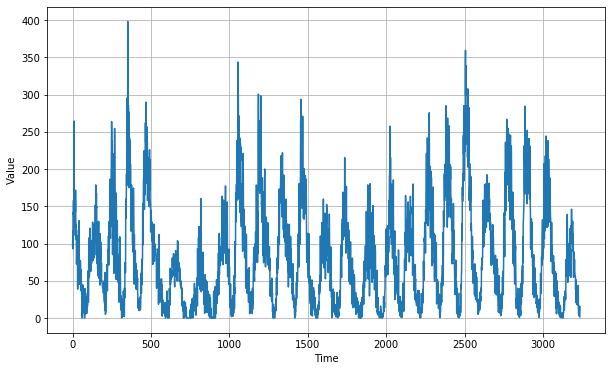

In [9]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [20]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), metrics = ['accuracy'])
history = model.fit(dataset,epochs=100,verbose=1)




Epoch 1/100
92/92 [==============================] - 1s 13ms/step - loss: 2170.1038 - accuracy: 0.0044
Epoch 2/100
92/92 [==============================] - 1s 8ms/step - loss: 1055.6615 - accuracy: 0.0014
Epoch 3/100
92/92 [==============================] - 1s 7ms/step - loss: 933.9475 - accuracy: 0.0010
Epoch 4/100
92/92 [==============================] - 1s 7ms/step - loss: 874.0208 - accuracy: 0.0010
Epoch 5/100
92/92 [==============================] - 1s 7ms/step - loss: 831.9690 - accuracy: 0.0010
Epoch 6/100
92/92 [==============================] - 1s 6ms/step - loss: 800.4579 - accuracy: 0.0010
Epoch 7/100
92/92 [==============================] - 1s 6ms/step - loss: 777.1892 - accuracy: 0.0010
Epoch 8/100
92/92 [==============================] - 1s 6ms/step - loss: 758.2333 - accuracy: 0.0010
Epoch 9/100
92/92 [==============================] - 1s 6ms/step - loss: 742.9305 - accuracy: 0.0010
Epoch 10/100
92/92 [==============================] - 1s 6ms/step - loss: 730.8292 - acc

(0.0009482717216128719,
 0.004758139032870325,
 504.6345912679037,
 2250.4848332743745)

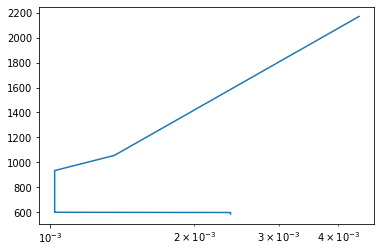

In [21]:
plt.semilogx(history.history['accuracy'], history.history['loss'])
plt.axis()

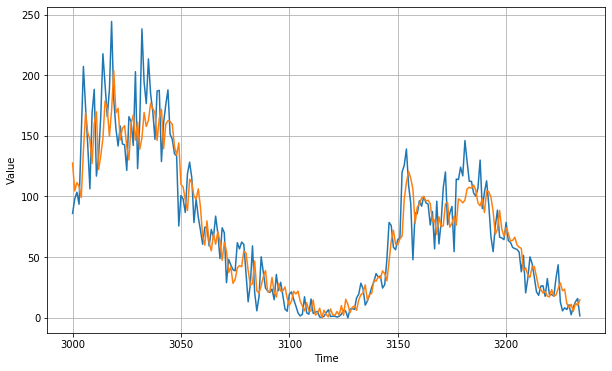

In [22]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

15.119391